<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Procesamiento del Lenguaje Natural 2021-22</div><br>
    <div style="font-size: x-large; color:gray">Aspect opinion extraction</div><br>
    <div style="font-size: large">María Barroso - Gloria del Valle</div><br></div><hr>
</div>

In [1]:
import json
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd

## Assignment 1: Review datasets

**yelp_hotels.json**: json containing 5,034 reviews generated by 4,148 Yelp users about 284 hotels.

**yelp_beauty_spas.json** and **yelp_restaurants.json**: which contain Yelp reviews about beauty/spa resorts and restaurants.

Each review (JSON record) has the following fields:
* *reviewerID*: the identifier of the user who wrote the review
* *asin*: the identifier of the reviewed hotel
* *reviewText*: the text of the user’s review about the hotel
* *overall*: the 1-5 Likert scale rating assigned by the user to the hotel

### Task 1.1
Loading all the hotel reviews from the Yelp hotel reviews file.

In [2]:
def load_all_json_yelp(data_name, data_path = 'yelp_dataset'):
    with open(f'{data_path}/{data_name}.json', encoding='utf-8') as f:
        reviews = json.load(f)
    numReviews = len(reviews)
    print(f'{data_name}: {numReviews} reviews loaded')
    return reviews

reviews_hotels = load_all_json_yelp('yelp_hotels')

yelp_hotels: 5034 reviews loaded


In [3]:
print(reviews_hotels[0])
print(reviews_hotels[0].get('reviewerID'))

{'reviewerID': 'qLCpuCWCyPb4G2vN-WZz-Q', 'asin': '8ZwO9VuLDWJOXmtAdc7LXQ', 'summary': 'summary', 'reviewText': "Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!", 'overall': 4.0}
qLCpuCWCyPb4G2vN-WZz-Q


### Task 1.2
Loading line by line the reviews from the Yelp beauty/spa resorts and restaurants reviews files

In [4]:
def load_by_line_json_yelp(data_name, data_path = 'yelp_dataset'):
    reviews = []
    with open(f'{data_path}/{data_name}.json', encoding='utf-8') as f:
        f.readline() # first line '['
        numReviews = 0
        while True:
            numReviews += 1
            line = f.readline().strip() # Get next line from file
            if line == ']': # end of file is reached ']'
                print(f'{data_name}: {numReviews} reviews loaded')
                break
            if line[-1] == ',':
                line = line[:-1]
            reviews.append(json.loads(line))
    return reviews

In [5]:
reviews_spas = load_by_line_json_yelp('yelp_beauty_spas')
print(reviews_spas[0])
print(reviews_spas[0].get('reviewerID'))

yelp_beauty_spas: 5580 reviews loaded
{'reviewerID': 'Xm8HXE1JHqscXe5BKf0GFQ', 'asin': 'WGNIYMeXPyoWav1APUq7jA', 'summary': 'summary', 'reviewText': "Good tattoo shop. Clean space, multiple artists to choose from and books of their work are available for you to look though and decide who's style most mirrors what you're looking for. I chose Jet to do a cover-up for me and he worked with me on the design and our ideas and communication flowed very well. He's a very personable guy, is friendly and keeps the conversation going while he's working on you, and he doesn't dick around (read: He starts to work and continues until the job is done). He's very professional and informative. Good customer service combines with talent at the craft.", 'overall': 4.0}
Xm8HXE1JHqscXe5BKf0GFQ


In [6]:
reviews_restaurants = load_by_line_json_yelp('yelp_restaurants')
print(reviews_restaurants[0])
print(reviews_restaurants[0].get('reviewerID'))

yelp_restaurants: 158431 reviews loaded
{'reviewerID': 'rLtl8ZkDX5vH5nAx9C3q5Q', 'asin': '9yKzy9PApeiPPOUJEtnvkg', 'summary': 'summary', 'reviewText': 'My wife took me here on my birthday for breakfast and it was excellent. The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure. Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning. It looked like the place fills up pretty quickly so the earlier you get here the better.Do yourself a favor and get their Bloody Mary. It was phenomenal and simply the best I\'ve ever had. I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it. It was amazing.While EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious. It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete. It was the best "toast" I\'ve ever had.An

### Task 1.3
Loading line by line* reviews on other domains like digital music from McAuley’s Amazon dataset2.

Una opción de leer linea por linea un json muy grande es utilizar la función *read_json* de pandas con el atributo 'lines' a True. Después se ha realizado una limpieza del dataframe (eliminado columnas que no estuviesen en el dataset yelp)

In [7]:
#def read_by_line_json_amazon(data_name, data_path = 'amazon_dataset'):
#    df = pd.read_json(f'{data_path}/{data_name}.json', lines=True)
#    df.drop(inplace=True, columns=['verified', 'reviewTime', 'reviewerName', 'reviewText', 'unixReviewTime', 'style', 'image', 'vote'])
#    return df.to_dict('records')

In [8]:
#fashion_reviews = read_by_line_json_amazon('digital_music')
#print(fashion_reviews[0])
#print(fashion_reviews[0].get('reviewerID'))

## Assignment 2: Aspect vocabularies

### Task 2.1
Loading (and printing on screen) the vocabulary of the aspects_hotels.csv
file, and directly using it to identify aspect references in the reviews. In particular, the aspects terms
could be mapped by exact matching with nouns appearing in the reviews. 

In [68]:
def load_aspects(data_name, data_path = 'aspects'):
    with open(f'{data_path}/{data_name}.csv', encoding='utf-8') as f:
        aspects = {}
        for line in f:
            key, synonymous = line.rstrip('\n').split(',')
            if key in aspects and synonymous not in aspects[key]:
                aspects[key].append(synonymous)
            else:
                aspects[key] = []
    return aspects

In [69]:
aspects_hotels = load_aspects('aspects_hotels')
aspects_hotels

{'amenities': ['amenities', 'services'],
 'atmosphere': ['atmospheres',
  'ambiance',
  'ambiances',
  'light',
  'lighting',
  'lights',
  'music'],
 'bar': ['bars', 'bartender', 'bartenders'],
 'bathrooms': ['bathrooms',
  'bath',
  'baths',
  'bathtub',
  'bathtubs',
  'shampoo',
  'shampoos',
  'shower',
  'showers',
  'towel',
  'towels',
  'tub',
  'tubs'],
 'bedrooms': ['bedrooms',
  'bed',
  'beds',
  'pillow',
  'pillows',
  'sheet',
  'sheets',
  'sleep',
  'suite',
  'suites'],
 'booking': ['book', 'reservation', 'reservations', 'reserve'],
 'breakfast': ['breakfasts',
  'morning',
  'mornings',
  'toast',
  'toasts',
  'moorning meal',
  'moorning menu'],
 'building': ['decor',
  'decoration',
  'decorations',
  'furniture',
  'furnitures',
  'garden',
  'gardens',
  'hall',
  'halls',
  'lobbies',
  'lobby',
  'lounge',
  'lounges',
  'patio',
  'patios',
  'salon',
  'salons',
  'spot',
  'spots'],
 'checking': ['check-in',
  'check in',
  'check ins',
  'check out',
  'c

### Task 2.2 

Generating or extending the lists of terms of each aspect with synonyms extracted from WordNet

In [70]:
def extend_aspects(aspects):
    for key in aspects:
        synsets = wn.synsets(key)
        for synset in synsets:
            lemmas = synset.lemma_names()
            aspects[key] = list(set(aspects[key]  + lemmas))
    return aspects

In [71]:
aspects_hotels = extend_aspects(aspects_hotels)
aspects_hotels

{'amenities': ['creature_comforts',
  'conveniences',
  'amenities',
  'agreeableness',
  'comforts',
  'amenity',
  'services'],
 'atmosphere': ['light',
  'music',
  'atmospheres',
  'atmospheric_state',
  'air',
  'ambience',
  'atmosphere',
  'ambiance',
  'ambiances',
  'standard_atmosphere',
  'standard_pressure',
  'aura',
  'lights',
  'lighting',
  'atm'],
 'bar': ['bartender',
  'bar',
  'banish',
  'ginmill',
  'legal_community',
  'blockade',
  'saloon',
  'streak',
  'bars',
  'exclude',
  'prevention',
  'block_off',
  'relegate',
  'stripe',
  'stop',
  'Browning_automatic_rifle',
  'BAR',
  'barricade',
  'block_up',
  'taproom',
  'legal_profession',
  'debar',
  'block',
  'measure',
  'barroom',
  'bartenders',
  'cake'],
 'bathrooms': ['bathtub',
  'baths',
  'bath',
  'shampoo',
  'tub',
  'shampoos',
  'lavatory',
  'bathtubs',
  'bathroom',
  'toilet',
  'shower',
  'towels',
  'bathrooms',
  'john',
  'tubs',
  'can',
  'showers',
  'towel',
  'lav',
  'privy'],

In [11]:
aspects_hotels['hotel'] = ['hotel', 'resort']
aspects_hotels['bedrooms'].append('room')
aspects_hotels['bedrooms'].append('rooms')
aspects_hotels['location'].append('landscaping')

### Task 2.3 
Managing vocabularies for additional Yelp or Amazon domains.

In [12]:
aspects_spas = load_aspects('aspects_spas')
aspects_spas = extend_aspects(aspects_spas)
aspects_spas

{'amenities': ['creature_comforts',
  'conveniences',
  'amenities',
  'agreeableness',
  'comforts',
  'amenity',
  'services'],
 'atmosphere': ['light',
  'music',
  'atmospheres',
  'atmospheric_state',
  'air',
  'ambiences',
  'ambience',
  'atmosphere',
  'ambiance',
  'ambiances',
  'standard_atmosphere',
  'standard_pressure',
  'aura',
  'lights',
  'lighting',
  'atm'],
 'bar': ['bartender',
  'bar',
  'banish',
  'ginmill',
  'legal_community',
  'blockade',
  'saloon',
  'streak',
  'bars',
  'exclude',
  'prevention',
  'block_off',
  'relegate',
  'stripe',
  'stop',
  'Browning_automatic_rifle',
  'BAR',
  'barricade',
  'block_up',
  'taproom',
  'legal_profession',
  'debar',
  'block',
  'measure',
  'barroom',
  'bartenders',
  'cake'],
 'bathrooms': ['bathtub',
  'baths',
  'bath',
  'shampoo',
  'tub',
  'shampoos',
  'lavatory',
  'bathtubs',
  'bathroom',
  'toilet',
  'shower',
  'towels',
  'bathrooms',
  'john',
  'tubs',
  'can',
  'showers',
  'towel',
  'la

In [13]:
aspects_restaurants = load_aspects('aspects_restaurants')
aspects_restaurants = extend_aspects(aspects_restaurants)
aspects_restaurants

{'appetizers': ['appetizer',
  'entree',
  'starters',
  'entrees',
  'appetizers',
  'starter',
  'appetiser'],
 'asian': ['sushi',
  'sushies',
  'curries',
  'Asian',
  'Asiatic',
  'curry',
  'noodles',
  'noodle'],
 'atmosphere': ['light',
  'music',
  'atmospheres',
  'atmospheric_state',
  'air',
  'ambience',
  'atmosphere',
  'ambiance',
  'ambiances',
  'standard_atmosphere',
  'standard_pressure',
  'aura',
  'lights',
  'lighting',
  'atm'],
 'bar': ['bartender',
  'bar',
  'banish',
  'ginmill',
  'legal_community',
  'blockade',
  'saloon',
  'streak',
  'bars',
  'exclude',
  'prevention',
  'block_off',
  'relegate',
  'stripe',
  'stop',
  'Browning_automatic_rifle',
  'BAR',
  'barricade',
  'block_up',
  'taproom',
  'legal_profession',
  'debar',
  'block',
  'measure',
  'barroom',
  'bartenders',
  'cake'],
 'booking': ['booking',
  'reservations',
  'book',
  'hold',
  'engagement',
  'reservation',
  'reserve'],
 'bread': ['clams',
  'breads',
  'kale',
  'staff

### Task 2.4
Identifying hidden/implicit aspect references in reviews. For instance, the example review of page 1 has references to the hotel’s location and transportation aspects, since there is “not much around the area” and "going by car to the hotel is recommendable".


For this task, we are going to considerer the hyponym of words. For example, that 'area' is a hyponym of 'location'.

## Assignment 3: Opinion Lexicon

### Task 3.1

Loading Liu’s opinion lexicon composed of positive and negative words, accessible as an NLKT corpus, and exploiting it to assign the polarity values to aspect opinions in assignment 4. Instead of this lexicon, you are allowed to use others, such as SentiWordNet.

In [14]:
#nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

negativeWords = opinion_lexicon.negative()
positiveWords = opinion_lexicon.positive()

In [15]:
#nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_sentiment(sentence):
    lemmatizer = WordNetLemmatizer()
    token = nltk.word_tokenize(sentence)
    after_tagging = nltk.pos_tag(token)
    sentiment = 0
    for word, tag in after_tagging:

        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            continue

        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())

        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
    return sentiment

get_sentiment('it is not a funny joke')

0.25

In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import VaderConstants

def get_vader_score(sent):
    sid = SentimentIntensityAnalyzer()
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    # Index ordered by polarity value
    idx = np.argmax(list(ss.values())[:-1])
    if idx==0: return -1.0
    if idx==1: return 0.0
    if idx==2: return 1.0

get_vader_score('it is not a funny joke')

-1.0

In [17]:
import spacy
#!python -m spacy download en_core_web_lg
file = nltk.data.load("vader_lexicon/vader_lexicon.txt")
nlp = spacy.load("en_core_web_lg")

2022-03-29 19:50:59.524829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 19:50:59.524867: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
# lexicon2 between -3, 3
lexicon = {}
# $:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
for l in file.split("\n"):
    word, polarity = l.strip().split("\t")[0:2]
    lexicon[word] = float(polarity)

In [19]:
lexicon

{'$:': -1.5,
 '%)': -0.4,
 '%-)': -1.5,
 '&-:': -0.4,
 '&:': -0.7,
 "( '}{' )": 1.6,
 '(%': -0.9,
 "('-:": 2.2,
 "(':": 2.3,
 '((-:': 2.1,
 '(*': 1.1,
 '(-%': -0.7,
 '(-*': 1.3,
 '(-:': 1.6,
 '(-:0': 2.8,
 '(-:<': -0.4,
 '(-:o': 1.5,
 '(-:O': 1.5,
 '(-:{': -0.1,
 '(-:|>*': 1.9,
 '(-;': 1.3,
 '(-;|': 2.1,
 '(8': 2.6,
 '(:': 2.2,
 '(:0': 2.4,
 '(:<': -0.2,
 '(:o': 2.5,
 '(:O': 2.5,
 '(;': 1.1,
 '(;<': 0.3,
 '(=': 2.2,
 '(?:': 2.1,
 '(^:': 1.5,
 '(^;': 1.5,
 '(^;0': 2.0,
 '(^;o': 1.9,
 '(o:': 1.6,
 ")':": -2.0,
 ")-':": -2.1,
 ')-:': -2.1,
 ')-:<': -2.2,
 ')-:{': -2.1,
 '):': -1.8,
 '):<': -1.9,
 '):{': -2.3,
 ');<': -2.6,
 '*)': 0.6,
 '*-)': 0.3,
 '*-:': 2.1,
 '*-;': 2.4,
 '*:': 1.9,
 '*<|:-)': 1.6,
 '*\\0/*': 2.3,
 '*^:': 1.6,
 ',-:': 1.2,
 "---'-;-{@": 2.3,
 '--<--<@': 2.2,
 '.-:': -1.2,
 '..###-:': -1.7,
 '..###:': -1.9,
 '/-:': -1.3,
 '/:': -1.3,
 '/:<': -1.4,
 '/=': -0.9,
 '/^:': -1.0,
 '/o:': -1.4,
 '0-8': 0.1,
 '0-|': -1.2,
 '0:)': 1.9,
 '0:-)': 1.4,
 '0:-3': 1.5,
 '0:03': 1.9,
 '

In [20]:
from spacy import displacy

doc = nlp("I do not think the hotel staff was friendly")
displacy.render(doc, style="dep")

### Task 3.2

Considering modifiers to adjust the polarity values of the aspect opinions in Assignment 4. The modifiers to use could be those provided with the NLTK Sentiment Analyzer (see Appendix G) and/or those given in modifiers.csv.

In [21]:
modifiers = pd.read_csv("modifiers/modifiers.csv", header = None, names=['modifier', 'value'] )
modifiers

,modifier,value
0,above,2.0
1,absolutely,2.0
2,abundantly,2.0
3,acutely,2.0
4,amazingly,2.0
...,...,...
295,violently,-1.0
296,whimsically,-1.0
297,wickedly,-1.0
298,wretchedly,-1.0


In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import VaderConstants

constants = VaderConstants()
print(constants.BOOSTER_DICT)

{'absolutely': 0.293, 'amazingly': 0.293, 'awfully': 0.293, 'completely': 0.293, 'considerably': 0.293, 'decidedly': 0.293, 'deeply': 0.293, 'effing': 0.293, 'enormously': 0.293, 'entirely': 0.293, 'especially': 0.293, 'exceptionally': 0.293, 'extremely': 0.293, 'fabulously': 0.293, 'flipping': 0.293, 'flippin': 0.293, 'fricking': 0.293, 'frickin': 0.293, 'frigging': 0.293, 'friggin': 0.293, 'fully': 0.293, 'fucking': 0.293, 'greatly': 0.293, 'hella': 0.293, 'highly': 0.293, 'hugely': 0.293, 'incredibly': 0.293, 'intensely': 0.293, 'majorly': 0.293, 'more': 0.293, 'most': 0.293, 'particularly': 0.293, 'purely': 0.293, 'quite': 0.293, 'really': 0.293, 'remarkably': 0.293, 'so': 0.293, 'substantially': 0.293, 'thoroughly': 0.293, 'totally': 0.293, 'tremendously': 0.293, 'uber': 0.293, 'unbelievably': 0.293, 'unusually': 0.293, 'utterly': 0.293, 'very': 0.293, 'almost': -0.293, 'barely': -0.293, 'hardly': -0.293, 'just enough': -0.293, 'kind of': -0.293, 'kinda': -0.293, 'kindof': -0.293,

## Assignment 4: Aspect opinions

Once the aspect vocabulary and opinion lexicons are loaded, the opinions about aspects have to be extracted
from the reviews. For this purpose, POS tagging, constituency and dependency parsing could be used.
- POS tagging would allow identifying the adjectives in the sentences.
- Constituency and dependency parsing would allow extracting the relations between nouns and adjectives and adverbs.

#### Task 4.1 -: 
Extracting the [aspect, aspect term, opinion word, polarity] tuples from the input reviews

In [23]:
import re

# Define a function to clean the text
def clean(text):
    # Removes all special characters and numericals leaving the alphabets
    text = re.sub(r"[()\"#/@;<>{}`+=~|!?]", "", text)
    text = re.sub(r"[.]", ". ", text)
    return text
    
def get_aspect(word, aspects_type):
    if word in aspects_type: return word
    for key in aspects_type:
        if word in aspects_type[key]: return key

def get_polarity(dict_inf):
    sentence = dict_inf['opinion_word'] + ' ' + dict_inf['aspect_term']
    polarity = get_vader_score(sentence)
    if polarity == 0.0:
        if get_sentiment(sentence) < 0.0: return -1.0
        elif get_sentiment(sentence) > 0.0: return 1.0
        else: return 0.0
    return polarity

# AUXILIAR FUNCTIONS
def insert_just_before(dict_inf, item_type, word1, word2):
    word_list =  dict_inf[item_type].split()
    idx = word_list.index(word1)
    new_split = [word2]
    new_split += word_list[idx:]
    dict_inf[item_type] = ' '.join(word_list[:idx] + new_split)
    return dict_inf

def save_and_reset_information(data, dict_inf, aspect):
    if aspect != None and 'opinion_word' in dict_inf:       
        dict_inf['aspect'] = aspect.upper()
        dict_inf['polarity'] = get_polarity(dict_inf)
        # save new info
        data = data.append(dict_inf, ignore_index=True)
    
    # reset
    dict_inf = {}
    aspect = None
    return data, dict_inf, aspect


# MAIN CODE RULES
def get_information(head, relation, dependent, data, dict_inf, aspect, aspects_type):
    word1, pos1 = head
    word2, pos2 = dependent
    
    word1 = word1.lower()
    word2 = word2.lower()
    
    if relation == 'amod' and pos1.startswith('NN') and pos2.startswith('JJ'):
        if 'opinion_word' in dict_inf and word1 not in dict_inf['aspect_term'].split():
            data, dict_inf, aspect = save_and_reset_information(data, dict_inf, aspect)
        
        if pos1 == 'NN' and aspect == None: aspect = get_aspect(word1, aspects_type)
        
        if 'opinion_word' in dict_inf: dict_inf['opinion_word'] += ' ' + word2
        else: dict_inf['opinion_word'] = word2
        
        if 'aspect_term' not in dict_inf: dict_inf['aspect_term'] = word1
    
    elif relation == 'compound' and pos1.startswith('NN') and pos2.startswith('NN'):
        if 'aspect_term' in dict_inf and word1 in dict_inf['aspect_term'].split():
            dict_inf = insert_just_before(dict_inf, 'aspect_term', word1, word2)
            
            if aspect == None: aspect = get_aspect(word2, aspects_type)
    
    elif relation == 'advmod' and (pos1.startswith('JJ') or pos1.startswith('CD')) and pos2.startswith('RB'):
        if 'opinion_word' in dict_inf and word1 in dict_inf['opinion_word'].split():
            dict_inf = insert_just_before(dict_inf, 'opinion_word', word1, word2)
        
    elif relation == 'fixed' and pos1.startswith('RB') and pos2.startswith('RB'):
        if 'opinion_word' in dict_inf and word1 in dict_inf['opinion_word'].split():
            dict_inf = insert_just_before(dict_inf, 'opinion_word', word1, word2)

    elif relation == 'conj' and pos1.startswith('JJ') and pos2.startswith('JJ'):
        if 'opinion_word' in dict_inf and word1 in dict_inf['opinion_word'].split():
            dict_inf['opinion_word'] += ', ' + word2

    elif relation == 'nsubj' and pos2.startswith('NN'):
        if 'opinion_word' in dict_inf and word1 not in dict_inf['aspect_term'].split():
            data, dict_inf, aspect = save_and_reset_information(data, dict_inf, aspect)
        
        if pos1.startswith('NN'):
            dict_inf['aspect_term'] = word1 + ' ' + word2
            aspect = get_aspect(word2, aspects_type)
        elif pos1.startswith('JJ') or pos1.startswith('CD'):
            dict_inf['aspect_term'] = word2
            dict_inf['opinion_word'] = word1
            aspect = get_aspect(word2, aspects_type)
    
    return data, dict_inf, aspect

In [24]:
import pandas as pd
from nltk.parse.corenlp import CoreNLPDependencyParser

def analyze_review(idx, review, aspects_type):
    data = pd.DataFrame(columns = ['aspect', 'opinion_word', 'aspect_term', 'polarity'])
    dependency_parser = CoreNLPDependencyParser()

    review = clean(review)
    sentences = nltk.sent_tokenize(review)
    for s in sentences:
        result, = dependency_parser.raw_parse(s)

        dict_inf, aspect = {}, None
        for head, relation, dependent in result.triples():
            data, dict_inf, aspect = get_information(head, relation, dependent, data, dict_inf, aspect, aspects_type)
        data, _, _ = save_and_reset_information(data, dict_inf, aspect)
    data['review_id'] = idx
    data = data.set_index('review_id')
    return data

In [72]:
idx = 0
review = reviews_hotels[idx].get("reviewText")
print(review)

data = analyze_review(idx, review, aspects_hotels)
data

Great hotel in Central Phoenix for a stay-cation, but not necessarily a place to stay out of town and without a car. Not much around the area, and unless you're familiar with downtown, I would rather have a guest stay in Old Town Scottsdale, etc. BUT if you do stay here, it's awesome. Great boutique rooms. Awesome pool that's happening in the summer. A GREAT rooftop patio bar, and a very very busy lobby with Gallo Blanco attached. A great place to stay, but have a car!


,aspect,opinion_word,aspect_term,polarity
review_id,,,,
0,SHOPPING,great,boutique rooms,1.0
0,POOL,awesome,pool,1.0
0,BAR,great,rooftop patio bar,1.0
0,BUILDING,very very busy,lobby,1.0


In [73]:
total_data = pd.DataFrame(columns = ['aspect', 'opinion_word', 'aspect_term', 'polarity'])
for idx in range(len(reviews_hotels)):
    review = reviews_hotels[idx].get("reviewText")
    data = analyze_review(idx, review, aspects_hotels)
    total_data = total_data.append(data)
total_data

KeyboardInterrupt: 

In [74]:
aspect = 'BAR'
total_data[total_data['aspect']==aspect].rename_axis('review_id')

,aspect,opinion_word,aspect_term,polarity
review_id,,,,
0,BAR,great,rooftop patio bar,1.0
24,BAR,also great,bar,1.0
73,BAR,mini,bar,0.0
118,BAR,small,lobby bar,-1.0


In [75]:
df_polarity = total_data.groupby('polarity').size().reset_index(name='count').set_index('polarity')
df_polarity

,count
polarity,
-1.0,79
0.0,92
1.0,326


<AxesSubplot:xlabel='polarity'>

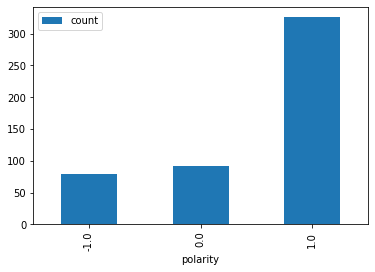

In [76]:
df_polarity.plot.bar()

In [77]:
df_polarity_review = total_data.rename_axis('review_id').reset_index().groupby(['review_id', 'polarity']).size().reset_index(name='counts').set_index('review_id')
df_polarity_review

,polarity,counts
review_id,,
0,1.0,4
1,0.0,1
2,1.0,5
3,0.0,1
3,1.0,2
...,...,...
171,-1.0,1
171,1.0,2
174,1.0,4


In [78]:
df_aspect = total_data.groupby('aspect').size().reset_index(name='count').set_index('aspect')
df_aspect

,count
aspect,
AMENITIES,2
ATMOSPHERE,9
BAR,4
BATHROOMS,36
BEDROOMS,41
BREAKFAST,30
BUILDING,32
CHECKING,3
CLEANLINESS,6


<AxesSubplot:xlabel='aspect'>

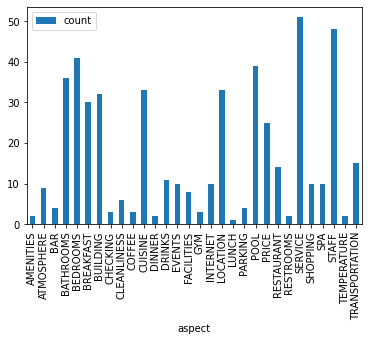

In [79]:
df_aspect.plot.bar()

In [80]:
df_aspect_polarity = total_data.groupby(['aspect','polarity']).size().reset_index(name='counts').set_index(['aspect','polarity'])
df_aspect_polarity

counts
aspect         polarity        
AMENITIES       1.0           2
ATMOSPHERE      0.0           4
                1.0           5
BAR            -1.0           1
                0.0           1
...                         ...
TEMPERATURE    -1.0           1
                1.0           1
TRANSPORTATION -1.0           4
                0.0           5
                1.0           6

[71 rows x 1 columns]

KeyError: 'BOOKING'

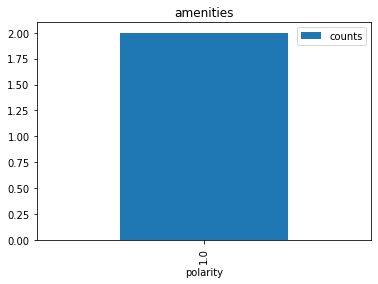

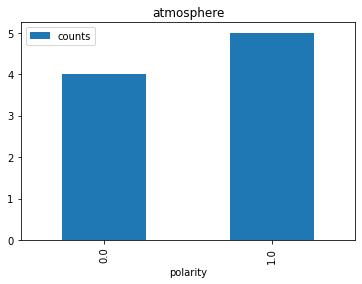

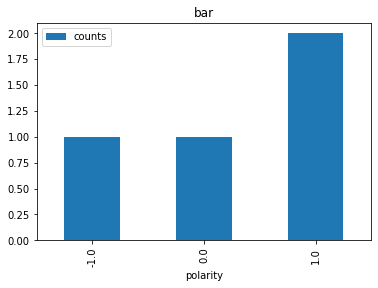

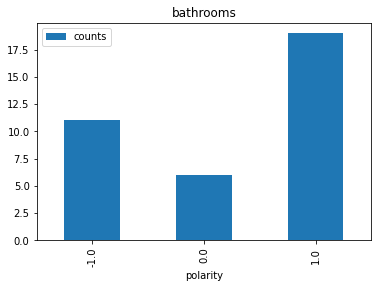

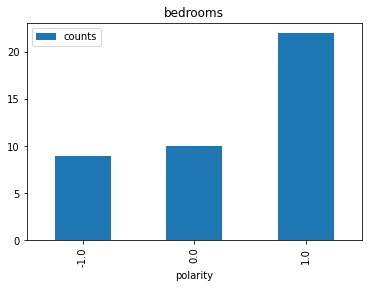

In [81]:
for aspect in aspects_hotels:
    df_aspect_polarity.loc[aspect.upper()].plot.bar(title=aspect)